In [1]:
%pylab inline
from matplotlib import pyplot as plt
from workflow.data import *
from workflow.features import *
import pandas as pd
import numpy as np
import seaborn as sns

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

plt.tight_layout
plt.rcParams.update({'font.size': 22})
rc('xtick', labelsize=15) 
rc('ytick', labelsize=15) 
figure(figsize(10,7))

Populating the interactive namespace from numpy and matplotlib


In [2]:
# connect to SQL database

username = 'psam071'
host = 'localhost'
dbname = 'citibike'

db = create_engine('postgres://%s%s/%s' % (username,host,dbname))
con = None

con = psycopg2.connect(database = dbname, user = username, host = host)

# Querying Data and transforming it

In [3]:
# query stations from 2015 that existed at the beginning of the data
# collecting period
query_stations2015 = """
    SELECT DISTINCT a.id, name, lat, long
    FROM features a
    LEFT JOIN stations b ON a.id = b.id
    WHERE a.date = '2015-03-01' AND tot_docks > 0
    ORDER BY a.id;
"""

stations2015 = pd.read_sql_query(query_stations2015, con)

In [4]:
stations2015 = stations2015.dropna()

In [5]:
# most unbalanced stations
query_unbal_stations = """
    SELECT a.id, abs(a.bikes_in - a.bikes_out) as flux,
                 abs(a.rbikes_in - a.rbikes_out) as rflux,
                 a.bikes_in, a.bikes_out,                                 
            c.name, neighborhood, borough, long, lat
    FROM   (SELECT id, sum(bikes_out) as bikes_out, sum(bikes_in) as bikes_in,
                sum(rbikes_in) as rbikes_in, sum(rbikes_out) as rbikes_out
            FROM features
            GROUP BY id) a
    JOIN neighborhoods b ON a.id = b.id
    JOIN stations c on b.id = c.id
    ORDER BY flux DESC;
"""

df_unbal_stations = pd.read_sql_query(query_unbal_stations, con)
df_unbal_stations = df_unbal_stations[df_unbal_stations.id.isin(stations2015.id)]
# pl = df_unbal_stations.head(20).plot(kind = 'barh', x = 'name', y = 'flux', stacked=True)
# pl.invert_yaxis()

In [7]:
def dfcol_into_sqllist(df, col):
    # converts a column in a pandas dataframe into a string for sql queries
    listy = list(df[col].unique())
    listy = listy[0:10]
    return "(" + str(listy)[1:-1] + ")"

string_of_unbal_stations = str(list(df_unbal_stations.id.unique()))[1:-1]
list_of_unbal_stations = list(df_unbal_stations.id)
df_unbal_stations.id.unique().shape

(290,)

In [9]:
# look at the patterns for the rebalanced stations
# make sure tot_docks > 0 (especially when calculating bikes available)

ids_to_see = dfcol_into_sqllist(df_unbal_stations, 'id')
# ids_to_see = '(' + str(['72'])[1:-1] + ')'

query = """
    SELECT a.id, a.date, a.hour, bikes_out, bikes_in, dayofweek, month, is_weekday,
            is_holiday, rbikes_out, rbikes_in, tot_docks, avail_bikes, avail_docks,
            precip, temp, long, lat, neighborhood, borough
    FROM features a
    LEFT JOIN weather b ON a.date = b.date AND a.hour = b.hour
    LEFT JOIN stations c ON a.id = c.id
    LEFT JOIN neighborhoods d ON a.id = d.id
    WHERE a.id in {} 
        AND tot_docks > 0
        AND borough = 'Manhattan'
    --WHERE tot_docks > 0
    ORDER BY a.id, a.date, a.hour;
""".format(ids_to_see)

df = pd.read_sql_query(query, con)
df.date = pd.to_datetime(df.date)

In [10]:
# make new features (percentages)
df = new_features(df)


In [38]:
# split data into 2015 (train) and 2016 (test) data
# 
data_cols = ['id','hour', 'month', 'is_weekday', 
             'precip', 'temp', 'pct_avail_bikes']#, 'pct_avail_docks']
# df = make_categorical(df, ['id', 'hour', 'month', 'is_weekday', 'is_holiday'])
hist_cols = ['mean_flux', 'yest_flux', 'last_week_flux']

df2015 = df[(df.date.dt.year == 2015)]
df2016 = df[(df.date.dt.year == 2016)]

# Prepare pipeline

### TPOT Regressor

In [16]:
# tpot regressor

from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split

# data = df[data_cols + hist_cols].sort_index()
# target = df.pct_flux

# X_train, X_test, y_train, y_test = train_test_split(data, target, 
#                                                     train_size = 0.75, test_size = 0.25)

X_train = df2015[data_cols]
y_train = df2015.pct_flux

X_test = df2016[data_cols]
y_test = df2016.pct_flux


tpot = TPOTRegressor(generations=2, population_size = 5, verbosity=2)
tpot.fit(X_train, y_train)
pred = tpot.predict(X_test)

/home/psamtik071/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Optimization Progress:  67%|██████▋   | 10/15 [01:32<01:36, 19.31s/pipeline]

Generation 1 - Current best internal CV score: 0.0259004802159


Generation 2 - Current best internal CV score: 0.025427992271

Best pipeline: RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.55, RandomForestRegressor__min_samples_leaf=9, RandomForestRegressor__min_samples_split=11, RandomForestRegressor__n_estimators=DEFAULT)


### RandomForestRegressor

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
X_train = df2015[data_cols + hist_cols]
y_train = df2015.pct_flux

X_test = df2016[data_cols + hist_cols]
y_test = df2016.pct_flux

reg = ExtraTreesRegressor(min_samples_leaf=11, min_samples_split=3, max_features = 0.85, n_estimators = 100,
                            n_jobs=-1)
reg.fit(X_train, y_train)
pred = reg.predict(X_test)

In [78]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

params = [{'min_samples_leaf': [14,16,18,19,20,21],
          'min_samples_split': [3,4,5,6],
          'max_features': [0.85,0.9,0.95,1.]}]


X_train = df2015[data_cols]
y_train = df2015.pct_flux#.apply(flux_conditions, 0.15)

X_test = df2016[data_cols]
y_test = df2016.pct_flux#.apply(flux_conditions, 0.15)

# reg = GridSearchCV(RandomForestRegressor(), params, cv=2, scoring = 'r2')
reg = RandomForestRegressor(min_samples_leaf=19, min_samples_split=6, max_features = 0.80,
                            n_jobs=-1)
reg.fit(X_train, y_train)
pred = reg.predict(X_test)


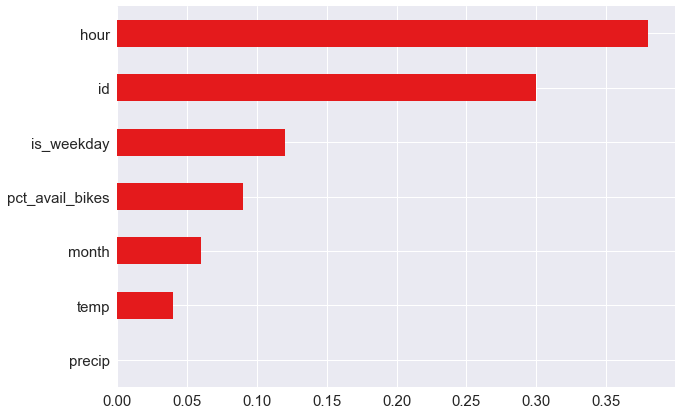

In [40]:
reg.feature_importances_.round(2)
importances = list(reg.feature_importances_.round(2))

features_dict = {}
for importance, col in zip(importances, data_cols):
    features_dict[col] = importance
  
features_dict
feature_imp = pd.Series(features_dict)
feature_imp.sort_values().plot(kind = 'barh')

In [ ]:
df2015.shape

In [70]:
stations2015[stations2015.id == 517]

,id,name,lat,long
282,517.0,Pershing Square South,40.751581,-73.97791


# Test Model

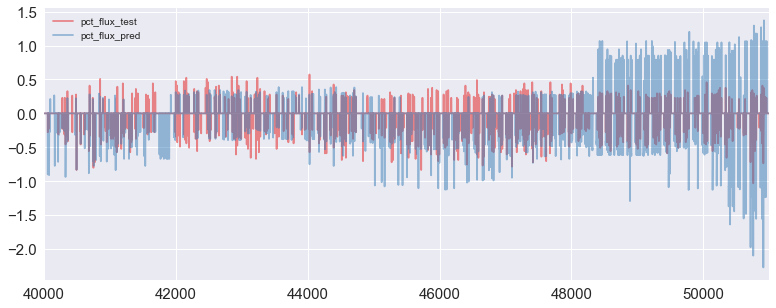

In [79]:
def merge_pred_test(pred, y_test):
    tests = pd.DataFrame()
    tests['pct_flux_test'] = y_test.reset_index().pct_flux
    tests['pct_flux_pred'] = pred
    return tests

def plot_pred_test(test,X_test):
    cmap= sns.color_palette('Set1')
    sns.set_palette(cmap)
    tests.iloc[40000:51000].plot(figsize = (13,5), alpha = 0.5)
#     X_test.reset_index().iloc[:].pct_avail_bikes.plot(alpha = 0.3)
    
   
tests = merge_pred_test(pred*2, y_test)
tests.pct_flux_test = tests.pct_flux_test.apply(flux_conditions, 0.2)
tests.pct_flux_pred = tests.pct_flux_pred.apply(flux_conditions, 0.2)
plot_pred_test(tests, X_test)

In [80]:
from sklearn.metrics import mean_squared_error, r2_score

def scoring_metrics(predicted, labeled):
    mse = mean_squared_error(predicted, labeled)
    r2 = r2_score(predicted, labeled)
    
    print 'MSE: {}'.format(mse)
    print 'R2: {}'.format(r2)
    
    
scoring_metrics(tests.pct_flux_pred, tests.pct_flux_test)
#     return mse, r2

# mean_squared_error(y_test, pred)
# r2_score(y_test, pred)
# explained_variance_score(y_test, pred)
# RegressorMixin.score(X_test, y_test)

MSE: 0.0378077883709
R2: 0.305140726869


# Miscellaneous Plotting

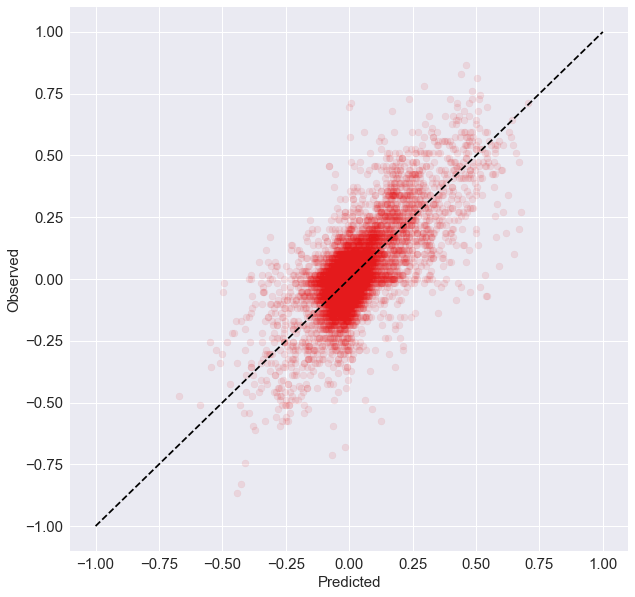

In [34]:
# prediction/observation plot

line = linspace(-1,1, num = 50)

fig = plt.figure(figsize = (10,10))
pl = fig.add_subplot(111)
pl.scatter(pred, y_test, alpha = 0.1)
pl.plot(line, line, c = 'k', linestyle = '--')
xlabel('Predicted',fontsize = 15)
ylabel('Observed',fontsize = 15)


In [32]:
# queries the entire features table to calculate pct_flux
ids_to_see = dfcol_into_sqllist(df_unbal_stations, 'id')

query = """
    SELECT a.id, a.date, a.hour, bikes_out, bikes_in, dayofweek, month, is_weekday,
            is_holiday, rebal_net_flux, tot_docks, avail_bikes, avail_docks,
            precip, snow, temp, c.long, c.lat
    FROM features a
    LEFT JOIN weather b ON a.date = b.date AND a.hour = b.hour
    LEFT JOIN stations c ON a.id = c.id
    WHERE tot_docks > 0 AND a.id in {}
    ORDER BY a.id, a.date, a.hour;
""".format(ids_to_see)

df = pd.read_sql_query(query, con)
df.date = pd.to_datetime(df.date)
df = new_features(df)

In [ ]:
# histogram of pct_flux compared to normal distribution

from scipy.stats import norm
x_axis = np.arange(-1,1,0.001)

df.pct_flux.plot(kind = 'hist', logy = True, bins=400, normed = True, alpha = 0.5)
plot(x_axis, norm.pdf(x_axis, df.pct_flux.mean(), df.pct_flux.std()))
xlim([-0.5,0.5])
ylim([0.001, None])
xlabel('Bike Flow', fontsize = 15)
ylabel('Frequency', fontsize = 15)

In [ ]:
df_flx.pct_flux.std()

In [ ]:
ids_to_see

In [ ]:
def plot_by_hour(df, cols, dock_id, dayofweek = 0):
    #plot hourly profile for any bike for any day
    grps = df.groupby(['id','dayofweek', 'hour']).mean()
    grps.xs((dock_id, dayofweek), level=('id', 'dayofweek'))[cols].plot()
    plt.xlabel('Hour', size = 20)
    legend(loc = 'best', prop = {'size':15})

In [ ]:
unbal_stations_list = df_unbal_stations[df_unbal_stations.id.isin(stations2015.id)].id
for id in list(unbal_stations_list)[0:5]:
    plot_by_hour(df,['pct_flux', 'pct_avail_bikes'], id, dayofweek=3)
    suptitle('Bike Activity for station {}'.format(id))

In [82]:
import pickle

PICKLE_FILENAME = 'regressor.pkl'

with open(PICKLE_FILENAME, "r") as reg_infile:
        reg = pickle.load(reg_infile)
        
reg

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.85, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=12,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [7]:
# most unbalanced stations
query_unbal_stations_byhr = """
    SELECT a.id,  a.hour, abs(a.bikes_in - a.bikes_out) as flux,
                 abs(a.rbikes_in - a.rbikes_out) as rflux,
                 a.bikes_in, a.bikes_out,
                 c.name, neighborhood, borough, long, lat
    FROM   (SELECT id, hour, sum(bikes_out) as bikes_out, sum(bikes_in) as bikes_in,
                sum(rbikes_in) as rbikes_in, sum(rbikes_out) as rbikes_out
            FROM features
            GROUP BY id, hour) a
    JOIN neighborhoods b ON a.id = b.id
    JOIN stations c on b.id = c.id
    ORDER BY flux DESC;
"""

df_unbal_stations_byhr = pd.read_sql_query(query_unbal_stations_byhr, con)
df_unbal_stations_byhr = df_unbal_stations_byhr[df_unbal_stations_byhr.id.isin(stations2015.id)]

In [10]:
df_unbal_stations_byhr.sort_values(['id','hour'])

,id,hour,flux,rflux,bikes_in,bikes_out,name,neighborhood,borough,long,lat
4717,72.0,0,308.0,4.0,593.0,285.0,W 52 St & 11 Ave,Clinton,Manhattan,-73.993929,40.767272
6780,72.0,1,155.0,13.0,331.0,176.0,W 52 St & 11 Ave,Clinton,Manhattan,-73.993929,40.767272
8729,72.0,2,80.0,2.0,198.0,118.0,W 52 St & 11 Ave,Clinton,Manhattan,-73.993929,40.767272
12317,72.0,3,15.0,1.0,84.0,99.0,W 52 St & 11 Ave,Clinton,Manhattan,-73.993929,40.767272
9438,72.0,4,63.0,7.0,89.0,152.0,W 52 St & 11 Ave,Clinton,Manhattan,-73.993929,40.767272
10449,72.0,5,41.0,12.0,308.0,267.0,W 52 St & 11 Ave,Clinton,Manhattan,-73.993929,40.767272
3911,72.0,6,420.0,12.0,1375.0,955.0,W 52 St & 11 Ave,Clinton,Manhattan,-73.993929,40.767272
4648,72.0,7,317.0,9.0,2170.0,2487.0,W 52 St & 11 Ave,Clinton,Manhattan,-73.993929,40.767272
338,72.0,8,3967.0,0.0,3809.0,7776.0,W 52 St & 11 Ave,Clinton,Manhattan,-73.993929,40.767272
1722,72.0,9,1126.0,13.0,3873.0,4999.0,W 52 St & 11 Ave,Clinton,Manhattan,-73.993929,40.767272


In [13]:

aggregators = {'bikes_in': 'sum', 'bikes_out': 'sum', 'long': 'max', 'lat': 'max'}
df_morn = df_unbal_stations_byhr[df_unbal_stations_byhr.hour.isin([7,8,9])].groupby('id').agg(aggregators)

In [14]:
df_morn.head()

,lat,bikes_out,bikes_in,long
id,,,,
72.0,40.767272,15262.0,9852.0,-73.993929
79.0,40.719116,6761.0,14061.0,-74.006667
82.0,40.711174,4448.0,2427.0,-74.000165
83.0,40.683826,2771.0,3311.0,-73.976323
116.0,40.741776,19561.0,22781.0,-74.001497


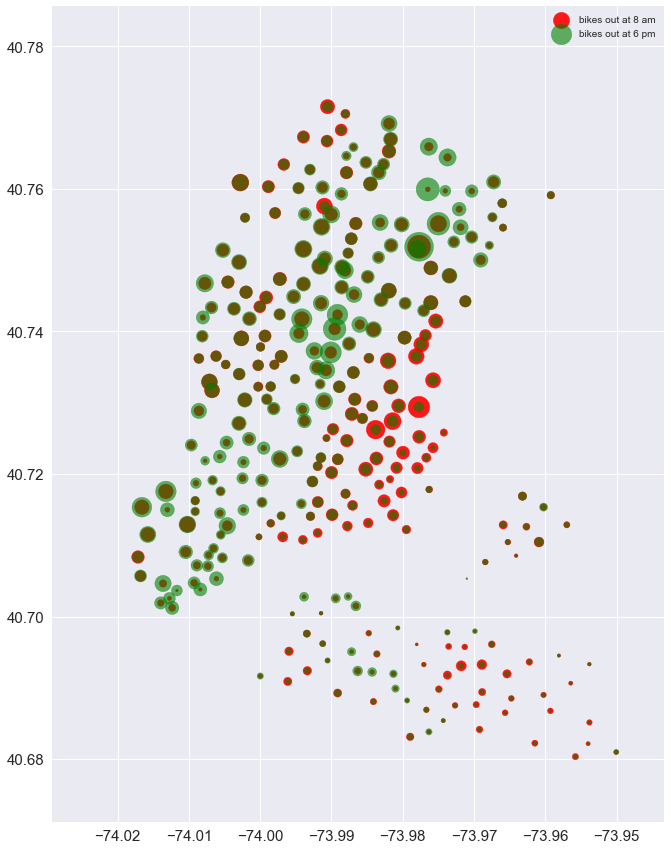

In [112]:
# map plot of difference between 8 am and 6 pm bike activity

aggregators = {'bikes_in': 'sum', 'bikes_out': 'sum'}
morn_cond = df_unbal_stations_byhr.hour.isin([8])
even_cond = df_unbal_stations_byhr.hour.isin([17])
grp_cols = ['id', 'lat', 'long', 'name']
df_morn = df_unbal_stations_byhr[morn_cond].groupby(grp_cols).agg(aggregators).reset_index()
df_even = df_unbal_stations_byhr[even_cond].groupby(grp_cols).agg(aggregators).reset_index()

fig = plt.figure(figsize = (15,15))
pl1 = fig.add_subplot(111)
pl1.scatter(df_morn.long, df_morn.lat,
           s = df_morn.bikes_out/50, color = 'r', alpha=0.9,
           label = 'bikes out at 8 am')
pl1.scatter(df_even.long, df_even.lat,
           s = df_even.bikes_out/50, color = 'g', alpha=0.6,
           label = 'bikes out at 6 pm')

plt.axes().set_aspect('equal')
plt.legend(loc='best')

In [19]:
df_morn.head()

,id,lat,long,name,bikes_out,bikes_in
0,72.0,40.767272,-73.993929,W 52 St & 11 Ave,15262.0,9852.0
1,79.0,40.719116,-74.006667,Franklin St & W Broadway,6761.0,14061.0
2,82.0,40.711174,-74.000165,St James Pl & Pearl St,4448.0,2427.0
3,83.0,40.683826,-73.976323,Atlantic Ave & Fort Greene Pl,2771.0,3311.0
4,116.0,40.741776,-74.001497,W 17 St & 8 Ave,19561.0,22781.0


In [117]:
import folium
from matplotlib.colors import Normalize, rgb2hex
import matplotlib.cm as cm

# norm = Normalize(start_station['trip count'].min(), start_station['trip count'].max())
# Get dark tileset from CartoBD (https://cartodb.com/basemaps)
tileset = r'http://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png'

station_map = folium.Map(location = [40.73, -73.985], width = 400, height = 700,
                        tiles = tileset,
                        attr = '&copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, &copy; <a href="http://cartodb.com/attributions">CartoDB</a>',
                        zoom_start = 13)


for index, row in df_morn.iterrows():
    morn_color = 'red' #rgb2hex(cm.YlOrRd(norm(row['trip count'])))
    folium.CircleMarker(
        location = [row['lat'], row['long']],
        popup = row['name'],
        radius = sqrt(row['bikes_out'])/15,
        color = None, fill_color = morn_color).add_to(station_map)
    
for index, row in df_even.iterrows():
    green_color = 'green' #rgb2hex(cm.YlOrRd(norm(row['trip count'])))
    folium.CircleMarker(
        location = [row['lat'], row['long']],
        popup = row['name'],
        radius = sqrt(row['bikes_out'])/15,
        color = None, fill_color = green_color).add_to(station_map)
    
station_map.save('station_map.html')

In [118]:
station_map

In [ ]:
# map plot of flow activity vs. rebalancing activity

fig = plt.figure(figsize = (10,15))
pl1 = fig.add_subplot(111)
pl1.scatter(df_unbal_stations.long, df_unbal_stations.lat,
           s = df_unbal_stations.flux/25, color = 'k', alpha=0.9,
           label = 'total bike flow')
pl1.scatter(df_unbal_stations.long, df_unbal_stations.lat,
           s = df_unbal_stations.rflux/25, color = 'y', alpha=0.6,
           label = 'total rebalancing flow')

plt.axes().set_aspect('equal')
plt.legend(loc='best')

## Sample Queries

In [ ]:
# find the most active stations by bikes_out
query_stations_out = """
    SELECT a.id, bikes_out, c.name, neighborhood, borough
    FROM   (SELECT id, sum(bikes_out) as bikes_out
            FROM features
            GROUP BY id) a
    JOIN neighborhoods b ON a.id = b.id
    JOIN stations c on b.id = c.id
    ORDER BY bikes_out DESC;
"""

df_stations_out = pd.read_sql_query(query_stations_out, con)
df_stations_out.head(20)

In [ ]:
# find the most active stations by bikes_in
query_stations_in = """
    SELECT a.id, bikes_in, c.name, neighborhood, borough
    FROM   (SELECT id, sum(bikes_in) as bikes_in
            FROM features
            GROUP BY id) a
    JOIN neighborhoods b ON a.id = b.id
    JOIN stations c ON b.id = c.id
    ORDER BY bikes_in DESC;
"""

df_stations_in = pd.read_sql_query(query_stations_in, con)
df_stations_in.head(20)

In [ ]:
# find the most active neighborhoods by bikes_out
query_hoods_out = """
        SELECT sum(a.bikes_out) as bikes_out, 
                b.neighborhood, b.borough
        FROM features a
        JOIN neighborhoods b on a.id = b.id
        GROUP BY borough, neighborhood
        ORDER BY bikes_out DESC;
"""

df_hoods_out = pd.read_sql_query(query_hoods_out, con)
df_hoods_out.head(20)

In [ ]:
# find the most active neighborhoods by bikes_in
query_hoods_in = """
        SELECT sum(a.bikes_in) as bikes_in, 
                b.neighborhood, b.borough
        FROM features a
        JOIN neighborhoods b on a.id = b.id
        GROUP BY borough, neighborhood
        ORDER BY bikes_in DESC;
"""

df_hoods_in = pd.read_sql_query(query_hoods_in, con)
df_hoods_in.head(20)

In [ ]:
# find the most unbalanced neighborhoods
query_hoods_in = """
        SELECT sum(a.bikes_in - a.bikes_out) as flux, 
                b.neighborhood, b.borough
        FROM features a
        JOIN neighborhoods b on a.id = b.id
        GROUP BY borough, neighborhood
        ORDER BY flux DESC;
"""

df_hoods_in = pd.read_sql_query(query_hoods_in, con)
df_hoods_in.head(20)

# Make dummy variables

In [ ]:
unique_values = [len(unique(df.iloc[:,i])) for i in xrange(df.shape[1])]
plt.bar(range(df.shape[1]), unique_values, width = 1, align='edge')

In [ ]:
# def dummies(col_name):
#     unique = sorted(data[col_name].unique())
#     return pd.get_dummies(unique)

# dummy_hour = pd.get_dummies(dummies('hour'))
# dummy_dayofweek = pd.get_dummies(dummies('dayofweek'))
# dummy_month = pd.get_dummies(dummies('month'))

In [ ]:
cat_data = df[['hour', 'dayofweek', 'month']]
dummy_hr = pd.get_dummies(cat_data['hour']).rename(columns = lambda x: 'hour' + '{:02}'.format(x))
dummy_dow = pd.get_dummies(cat_data['dayofweek']).rename(columns = lambda x: 'day' + '{:02.0f}'.format(x))
dummy_mo = pd.get_dummies(cat_data['month']).rename(columns = lambda x: 'month' + '{:02.0f}'.format(x))

In [ ]:
dummy_df = pd.concat([df, dummy_hr, dummy_dow, dummy_mo], axis = 1)
dummy_df.drop(['hour', 'month', 'dayofweek'], axis=1, inplace=True)
dummy_df.drop(['id', 'date', 'bikes_out', 'bikes_in', 'rebal_net_flux',
              'avail_bikes', 'avail_docks', 'tot_docks', 'flux'], axis = 1, inplace = True)
dummy_df.head()